In [22]:
import os
import librosa
from librosa import display
import numpy as np
from matplotlib import pyplot as plt
import time
import random


import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import datetime
from matplotlib import pyplot as plt
from pretty_confusion_matrix import pp_matrix_from_data

# Listing all samples

In [23]:
DATASET_PATH = "samples"
TRAIN_VAL_SPLIT = 0.1

samples = os.listdir(DATASET_PATH)
random.shuffle(samples)

# EmotionsDict = {'N': 'Neutral', 'F':'Fear', 'H':'Happiness', 'S':'Sadness', 'W':'Surprise', 'A':'Angry'}
# EmotionsDict = {'N': 0, 'F': 1, 'H': 2, 'S': 3, 'W': 4, 'A': 5}
EmotionsDict = {'N': 0, 'H': 1, 'S': 2, 'A': 3}
emotions = [EmotionsDict[x[3]] for x in samples]

# print(set(emotions))

# Preprocessing data and creating features

In [24]:
sr = 44100

SIG_LENGTH = 200

mfccs = []

for s in samples:
    t1 = time.time()

    sig, sr = librosa.load(f'{DATASET_PATH}/{s}', sr=sr)
    sig, _ = librosa.effects.trim(sig) # trimming beginning and ending silence


    # MFCC config
    WinLen = int(0.040 * sr) # 40 milisecond
    WinHop = WinLen // 2
    
    sig_mfcc = librosa.feature.mfcc(y=librosa.power_to_db(sig), sr=sr, n_mfcc=12, fmax=sr//2)

    # cutting every longer sequence than SIG_LENGTH and padding any sequence shorter than SIG_LENGTH
    if sig_mfcc.shape[1] < SIG_LENGTH:
        sig_mfcc = np.pad(sig_mfcc, [(0, 0), (0, SIG_LENGTH - sig_mfcc.shape[1])], mode='symmetric')
    elif sig_mfcc.shape[1] > SIG_LENGTH:
        sig_mfcc = sig_mfcc[:, :SIG_LENGTH]
    
    sig_mfcc = sig_mfcc.transpose()
    mfccs.append(sig_mfcc)

In [25]:
mfccs = np.array(mfccs)
emotions = np.array(emotions)

ds_len = mfccs.shape[0]
split_point = int(ds_len*(1-TRAIN_VAL_SPLIT))

avg = mfccs.mean()
std = mfccs.std()

mfccs = (mfccs - avg) / std # normalization

# mfccs = np.expand_dims(mfccs, axis=-1)

train_x = mfccs[:split_point]
train_y = emotions[:split_point]

val_x = mfccs[split_point:]
val_y = emotions[split_point:]

# print(mfccs.mean(), mfccs.std())

In [26]:
BATCH_SIZE = 16
LAYERS_ACTIVATION = 'relu'
LOSS_FUNCTION = 'sparse_categorical_crossentropy'

EPOCHS = 200

def get_model():
    model = tf.keras.Sequential([
              tf.keras.layers.Conv1D(256, 11),
              tf.keras.layers.MaxPool1D(3),
              tf.keras.layers.Conv1D(128, 7),
              tf.keras.layers.MaxPool1D(3),
              tf.keras.layers.Conv1D(64, 7),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(64, activation=LAYERS_ACTIVATION),
              tf.keras.layers.Dense(4, activation=tf.keras.activations.softmax)               
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=LOSS_FUNCTION, metrics=['accuracy'])
    return model

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_filepath = 'tmp/checkpoint'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
backup_callback = tf.keras.callbacks.BackupAndRestore(backup_dir="tmp/backup")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath+"/{epoch:02d}-{val_accuracy:.2f}",
        monitor='val_accuracy',
        mode='max',
        save_freq='epoch',
        period=1,
        save_best_only=True)


model = get_model()
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=EPOCHS, 
batch_size=BATCH_SIZE, callbacks=[tensorboard_callback, model_checkpoint_callback, backup_callback])

Epoch 1/200
84/84 [==============================] - ETA: 0s - loss: 1.4079 - accuracy: 0.2567

INFO:tensorflow:Assets written to: tmp/checkpoint/01-0.26/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/01-0.26/assets


84/84 [==============================] - 7s 60ms/step - loss: 1.4079 - accuracy: 0.2567 - val_loss: 1.4523 - val_accuracy: 0.2550
Epoch 2/200
83/84 [============================>.] - ETA: 0s - loss: 1.3685 - accuracy: 0.3253

INFO:tensorflow:Assets written to: tmp/checkpoint/02-0.26/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/02-0.26/assets


84/84 [==============================] - 5s 60ms/step - loss: 1.3675 - accuracy: 0.3284 - val_loss: 1.3659 - val_accuracy: 0.2617
Epoch 3/200
84/84 [==============================] - ETA: 0s - loss: 1.3382 - accuracy: 0.3463

INFO:tensorflow:Assets written to: tmp/checkpoint/03-0.33/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/03-0.33/assets


84/84 [==============================] - 5s 60ms/step - loss: 1.3382 - accuracy: 0.3463 - val_loss: 1.3436 - val_accuracy: 0.3289
Epoch 4/200
84/84 [==============================] - 4s 43ms/step - loss: 1.3281 - accuracy: 0.3649 - val_loss: 1.3200 - val_accuracy: 0.3020
Epoch 5/200
84/84 [==============================] - ETA: 0s - loss: 1.2979 - accuracy: 0.3821

INFO:tensorflow:Assets written to: tmp/checkpoint/05-0.36/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/05-0.36/assets


84/84 [==============================] - 5s 54ms/step - loss: 1.2979 - accuracy: 0.3821 - val_loss: 1.3265 - val_accuracy: 0.3624
Epoch 6/200
84/84 [==============================] - 3s 35ms/step - loss: 1.2844 - accuracy: 0.4007 - val_loss: 1.3095 - val_accuracy: 0.3423
Epoch 7/200
83/84 [============================>.] - ETA: 0s - loss: 1.2609 - accuracy: 0.4239

INFO:tensorflow:Assets written to: tmp/checkpoint/07-0.48/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/07-0.48/assets


84/84 [==============================] - 4s 46ms/step - loss: 1.2605 - accuracy: 0.4231 - val_loss: 1.2828 - val_accuracy: 0.4832
Epoch 8/200
84/84 [==============================] - 3s 35ms/step - loss: 1.2243 - accuracy: 0.4597 - val_loss: 1.2594 - val_accuracy: 0.3960
Epoch 9/200
84/84 [==============================] - 3s 36ms/step - loss: 1.1936 - accuracy: 0.4784 - val_loss: 1.2006 - val_accuracy: 0.4698
Epoch 10/200
84/84 [==============================] - 3s 35ms/step - loss: 1.1568 - accuracy: 0.4993 - val_loss: 1.2022 - val_accuracy: 0.4430
Epoch 11/200
83/84 [============================>.] - ETA: 0s - loss: 1.1472 - accuracy: 0.5083

INFO:tensorflow:Assets written to: tmp/checkpoint/11-0.49/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/11-0.49/assets


84/84 [==============================] - 4s 46ms/step - loss: 1.1481 - accuracy: 0.5075 - val_loss: 1.1784 - val_accuracy: 0.4899
Epoch 12/200
83/84 [============================>.] - ETA: 0s - loss: 1.0847 - accuracy: 0.5527

INFO:tensorflow:Assets written to: tmp/checkpoint/12-0.52/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/12-0.52/assets


84/84 [==============================] - 4s 45ms/step - loss: 1.0858 - accuracy: 0.5522 - val_loss: 1.1487 - val_accuracy: 0.5235
Epoch 13/200
84/84 [==============================] - 3s 35ms/step - loss: 1.0574 - accuracy: 0.5784 - val_loss: 1.1803 - val_accuracy: 0.5235
Epoch 14/200
84/84 [==============================] - ETA: 0s - loss: 1.0253 - accuracy: 0.5724

INFO:tensorflow:Assets written to: tmp/checkpoint/14-0.56/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/14-0.56/assets


84/84 [==============================] - 4s 51ms/step - loss: 1.0253 - accuracy: 0.5724 - val_loss: 1.0692 - val_accuracy: 0.5638
Epoch 15/200
84/84 [==============================] - 3s 40ms/step - loss: 0.9823 - accuracy: 0.6045 - val_loss: 1.0836 - val_accuracy: 0.5369
Epoch 16/200
84/84 [==============================] - 3s 35ms/step - loss: 0.9554 - accuracy: 0.6127 - val_loss: 1.1109 - val_accuracy: 0.5235
Epoch 17/200
83/84 [============================>.] - ETA: 0s - loss: 0.9081 - accuracy: 0.6416

INFO:tensorflow:Assets written to: tmp/checkpoint/17-0.59/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/17-0.59/assets


84/84 [==============================] - 4s 49ms/step - loss: 0.9058 - accuracy: 0.6425 - val_loss: 1.0184 - val_accuracy: 0.5906
Epoch 18/200
84/84 [==============================] - 3s 35ms/step - loss: 0.8557 - accuracy: 0.6657 - val_loss: 1.0586 - val_accuracy: 0.5436
Epoch 19/200
84/84 [==============================] - 3s 35ms/step - loss: 0.8184 - accuracy: 0.6769 - val_loss: 1.0204 - val_accuracy: 0.5839
Epoch 20/200
83/84 [============================>.] - ETA: 0s - loss: 0.7803 - accuracy: 0.7078

INFO:tensorflow:Assets written to: tmp/checkpoint/20-0.60/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/20-0.60/assets


84/84 [==============================] - 4s 45ms/step - loss: 0.7821 - accuracy: 0.7082 - val_loss: 0.9649 - val_accuracy: 0.6040
Epoch 21/200
83/84 [============================>.] - ETA: 0s - loss: 0.7393 - accuracy: 0.7297

INFO:tensorflow:Assets written to: tmp/checkpoint/21-0.61/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/21-0.61/assets


84/84 [==============================] - 4s 46ms/step - loss: 0.7389 - accuracy: 0.7299 - val_loss: 0.9534 - val_accuracy: 0.6107
Epoch 22/200
83/84 [============================>.] - ETA: 0s - loss: 0.7128 - accuracy: 0.7312

INFO:tensorflow:Assets written to: tmp/checkpoint/22-0.62/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/22-0.62/assets


84/84 [==============================] - 4s 45ms/step - loss: 0.7132 - accuracy: 0.7313 - val_loss: 0.9594 - val_accuracy: 0.6174
Epoch 23/200
83/84 [============================>.] - ETA: 0s - loss: 0.6923 - accuracy: 0.7485

INFO:tensorflow:Assets written to: tmp/checkpoint/23-0.62/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/23-0.62/assets


84/84 [==============================] - 4s 45ms/step - loss: 0.6915 - accuracy: 0.7493 - val_loss: 0.9019 - val_accuracy: 0.6242
Epoch 24/200
84/84 [==============================] - 3s 35ms/step - loss: 0.6497 - accuracy: 0.7627 - val_loss: 1.0248 - val_accuracy: 0.5705
Epoch 25/200
84/84 [==============================] - 3s 35ms/step - loss: 0.6350 - accuracy: 0.7776 - val_loss: 0.9560 - val_accuracy: 0.6174
Epoch 26/200
84/84 [==============================] - 3s 35ms/step - loss: 0.6235 - accuracy: 0.7724 - val_loss: 0.9853 - val_accuracy: 0.5772
Epoch 27/200
84/84 [==============================] - 3s 35ms/step - loss: 0.5905 - accuracy: 0.7754 - val_loss: 0.9330 - val_accuracy: 0.5839
Epoch 28/200
84/84 [==============================] - 3s 39ms/step - loss: 0.5418 - accuracy: 0.8097 - val_loss: 0.8911 - val_accuracy: 0.6040
Epoch 29/200
84/84 [==============================] - 3s 37ms/step - loss: 0.5152 - accuracy: 0.8179 - val_loss: 0.8899 - val_accuracy: 0.6242
Epoch 30/200

INFO:tensorflow:Assets written to: tmp/checkpoint/32-0.64/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/32-0.64/assets


84/84 [==============================] - 4s 47ms/step - loss: 0.4501 - accuracy: 0.8560 - val_loss: 0.8382 - val_accuracy: 0.6376
Epoch 33/200
84/84 [==============================] - 3s 35ms/step - loss: 0.4119 - accuracy: 0.8746 - val_loss: 0.8549 - val_accuracy: 0.6309
Epoch 34/200
84/84 [==============================] - 3s 35ms/step - loss: 0.3969 - accuracy: 0.8746 - val_loss: 0.9079 - val_accuracy: 0.6174
Epoch 35/200
83/84 [============================>.] - ETA: 0s - loss: 0.3642 - accuracy: 0.8788

INFO:tensorflow:Assets written to: tmp/checkpoint/35-0.64/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/35-0.64/assets


84/84 [==============================] - 4s 46ms/step - loss: 0.3635 - accuracy: 0.8791 - val_loss: 0.8724 - val_accuracy: 0.6443
Epoch 36/200
84/84 [==============================] - 3s 35ms/step - loss: 0.3345 - accuracy: 0.9104 - val_loss: 1.0162 - val_accuracy: 0.5906
Epoch 37/200
83/84 [============================>.] - ETA: 0s - loss: 0.3332 - accuracy: 0.8908

INFO:tensorflow:Assets written to: tmp/checkpoint/37-0.65/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/37-0.65/assets


84/84 [==============================] - 4s 49ms/step - loss: 0.3334 - accuracy: 0.8910 - val_loss: 0.8654 - val_accuracy: 0.6510
Epoch 38/200
83/84 [============================>.] - ETA: 0s - loss: 0.3240 - accuracy: 0.9036

INFO:tensorflow:Assets written to: tmp/checkpoint/38-0.68/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/38-0.68/assets


84/84 [==============================] - 4s 45ms/step - loss: 0.3239 - accuracy: 0.9030 - val_loss: 0.9180 - val_accuracy: 0.6779
Epoch 39/200
84/84 [==============================] - 3s 36ms/step - loss: 0.2817 - accuracy: 0.9164 - val_loss: 0.8733 - val_accuracy: 0.6577
Epoch 40/200
83/84 [============================>.] - ETA: 0s - loss: 0.2670 - accuracy: 0.9232

INFO:tensorflow:Assets written to: tmp/checkpoint/40-0.68/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/40-0.68/assets


84/84 [==============================] - 4s 45ms/step - loss: 0.2695 - accuracy: 0.9224 - val_loss: 0.8749 - val_accuracy: 0.6846
Epoch 41/200
84/84 [==============================] - 3s 34ms/step - loss: 0.2438 - accuracy: 0.9351 - val_loss: 0.9073 - val_accuracy: 0.6644
Epoch 42/200
84/84 [==============================] - 3s 35ms/step - loss: 0.2359 - accuracy: 0.9313 - val_loss: 0.9750 - val_accuracy: 0.6443
Epoch 43/200
84/84 [==============================] - 3s 35ms/step - loss: 0.2150 - accuracy: 0.9425 - val_loss: 0.9030 - val_accuracy: 0.6644
Epoch 44/200
84/84 [==============================] - 3s 35ms/step - loss: 0.2265 - accuracy: 0.9366 - val_loss: 0.9468 - val_accuracy: 0.6577
Epoch 45/200
84/84 [==============================] - 3s 40ms/step - loss: 0.1826 - accuracy: 0.9619 - val_loss: 0.9142 - val_accuracy: 0.6577
Epoch 46/200
84/84 [==============================] - 4s 44ms/step - loss: 0.1657 - accuracy: 0.9657 - val_loss: 1.0172 - val_accuracy: 0.6510
Epoch 47/200

INFO:tensorflow:Assets written to: tmp/checkpoint/51-0.69/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/51-0.69/assets


84/84 [==============================] - 4s 48ms/step - loss: 0.1272 - accuracy: 0.9761 - val_loss: 1.0405 - val_accuracy: 0.6913
Epoch 52/200
84/84 [==============================] - 3s 35ms/step - loss: 0.1042 - accuracy: 0.9828 - val_loss: 1.0235 - val_accuracy: 0.6510
Epoch 53/200
84/84 [==============================] - 3s 36ms/step - loss: 0.1144 - accuracy: 0.9784 - val_loss: 1.0138 - val_accuracy: 0.6779
Epoch 54/200
84/84 [==============================] - 3s 36ms/step - loss: 0.0879 - accuracy: 0.9888 - val_loss: 1.0327 - val_accuracy: 0.6913
Epoch 55/200
84/84 [==============================] - 3s 37ms/step - loss: 0.0857 - accuracy: 0.9866 - val_loss: 1.0619 - val_accuracy: 0.6577
Epoch 56/200
84/84 [==============================] - 3s 38ms/step - loss: 0.0722 - accuracy: 0.9918 - val_loss: 1.0683 - val_accuracy: 0.6846
Epoch 57/200
84/84 [==============================] - 3s 37ms/step - loss: 0.0656 - accuracy: 0.9940 - val_loss: 1.0853 - val_accuracy: 0.6711
Epoch 58/200

INFO:tensorflow:Assets written to: tmp/checkpoint/59-0.70/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/59-0.70/assets


84/84 [==============================] - 4s 47ms/step - loss: 0.0604 - accuracy: 0.9955 - val_loss: 1.0585 - val_accuracy: 0.7047
Epoch 60/200
84/84 [==============================] - 3s 36ms/step - loss: 0.0488 - accuracy: 0.9993 - val_loss: 1.1063 - val_accuracy: 0.6644
Epoch 61/200
84/84 [==============================] - 3s 36ms/step - loss: 0.0576 - accuracy: 0.9925 - val_loss: 1.1543 - val_accuracy: 0.6711
Epoch 62/200
84/84 [==============================] - 3s 36ms/step - loss: 0.0503 - accuracy: 0.9970 - val_loss: 1.2130 - val_accuracy: 0.6846
Epoch 63/200
84/84 [==============================] - 3s 39ms/step - loss: 0.0433 - accuracy: 0.9970 - val_loss: 1.1072 - val_accuracy: 0.6913
Epoch 64/200
83/84 [============================>.] - ETA: 0s - loss: 0.0373 - accuracy: 0.9992

INFO:tensorflow:Assets written to: tmp/checkpoint/64-0.71/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/64-0.71/assets


84/84 [==============================] - 4s 51ms/step - loss: 0.0374 - accuracy: 0.9993 - val_loss: 1.1171 - val_accuracy: 0.7114
Epoch 65/200
84/84 [==============================] - 3s 36ms/step - loss: 0.0330 - accuracy: 0.9993 - val_loss: 1.1605 - val_accuracy: 0.6779
Epoch 66/200
84/84 [==============================] - 3s 36ms/step - loss: 0.0346 - accuracy: 0.9993 - val_loss: 1.1832 - val_accuracy: 0.6711
Epoch 67/200
84/84 [==============================] - 3s 37ms/step - loss: 0.0294 - accuracy: 1.0000 - val_loss: 1.2262 - val_accuracy: 0.6510
Epoch 68/200
84/84 [==============================] - 3s 36ms/step - loss: 0.0249 - accuracy: 1.0000 - val_loss: 1.2115 - val_accuracy: 0.7047
Epoch 69/200
84/84 [==============================] - 3s 37ms/step - loss: 0.0225 - accuracy: 1.0000 - val_loss: 1.1855 - val_accuracy: 0.7114
Epoch 70/200
84/84 [==============================] - 3s 38ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 1.1906 - val_accuracy: 0.7047
Epoch 71/200

INFO:tensorflow:Assets written to: tmp/checkpoint/98-0.72/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/98-0.72/assets


84/84 [==============================] - 4s 48ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.4857 - val_accuracy: 0.7181
Epoch 99/200
84/84 [==============================] - 3s 36ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.5264 - val_accuracy: 0.7047
Epoch 100/200
84/84 [==============================] - 3s 36ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.5557 - val_accuracy: 0.6779
Epoch 101/200
84/84 [==============================] - 3s 37ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.5567 - val_accuracy: 0.6980
Epoch 102/200
84/84 [==============================] - 3s 37ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.5425 - val_accuracy: 0.7047
Epoch 103/200
84/84 [==============================] - 4s 46ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.5767 - val_accuracy: 0.7047
Epoch 104/200
84/84 [==============================] - 4s 53ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.5793 - val_accuracy: 0.7181
Epoch 1

5/5 [==============================] - 0s 20ms/step


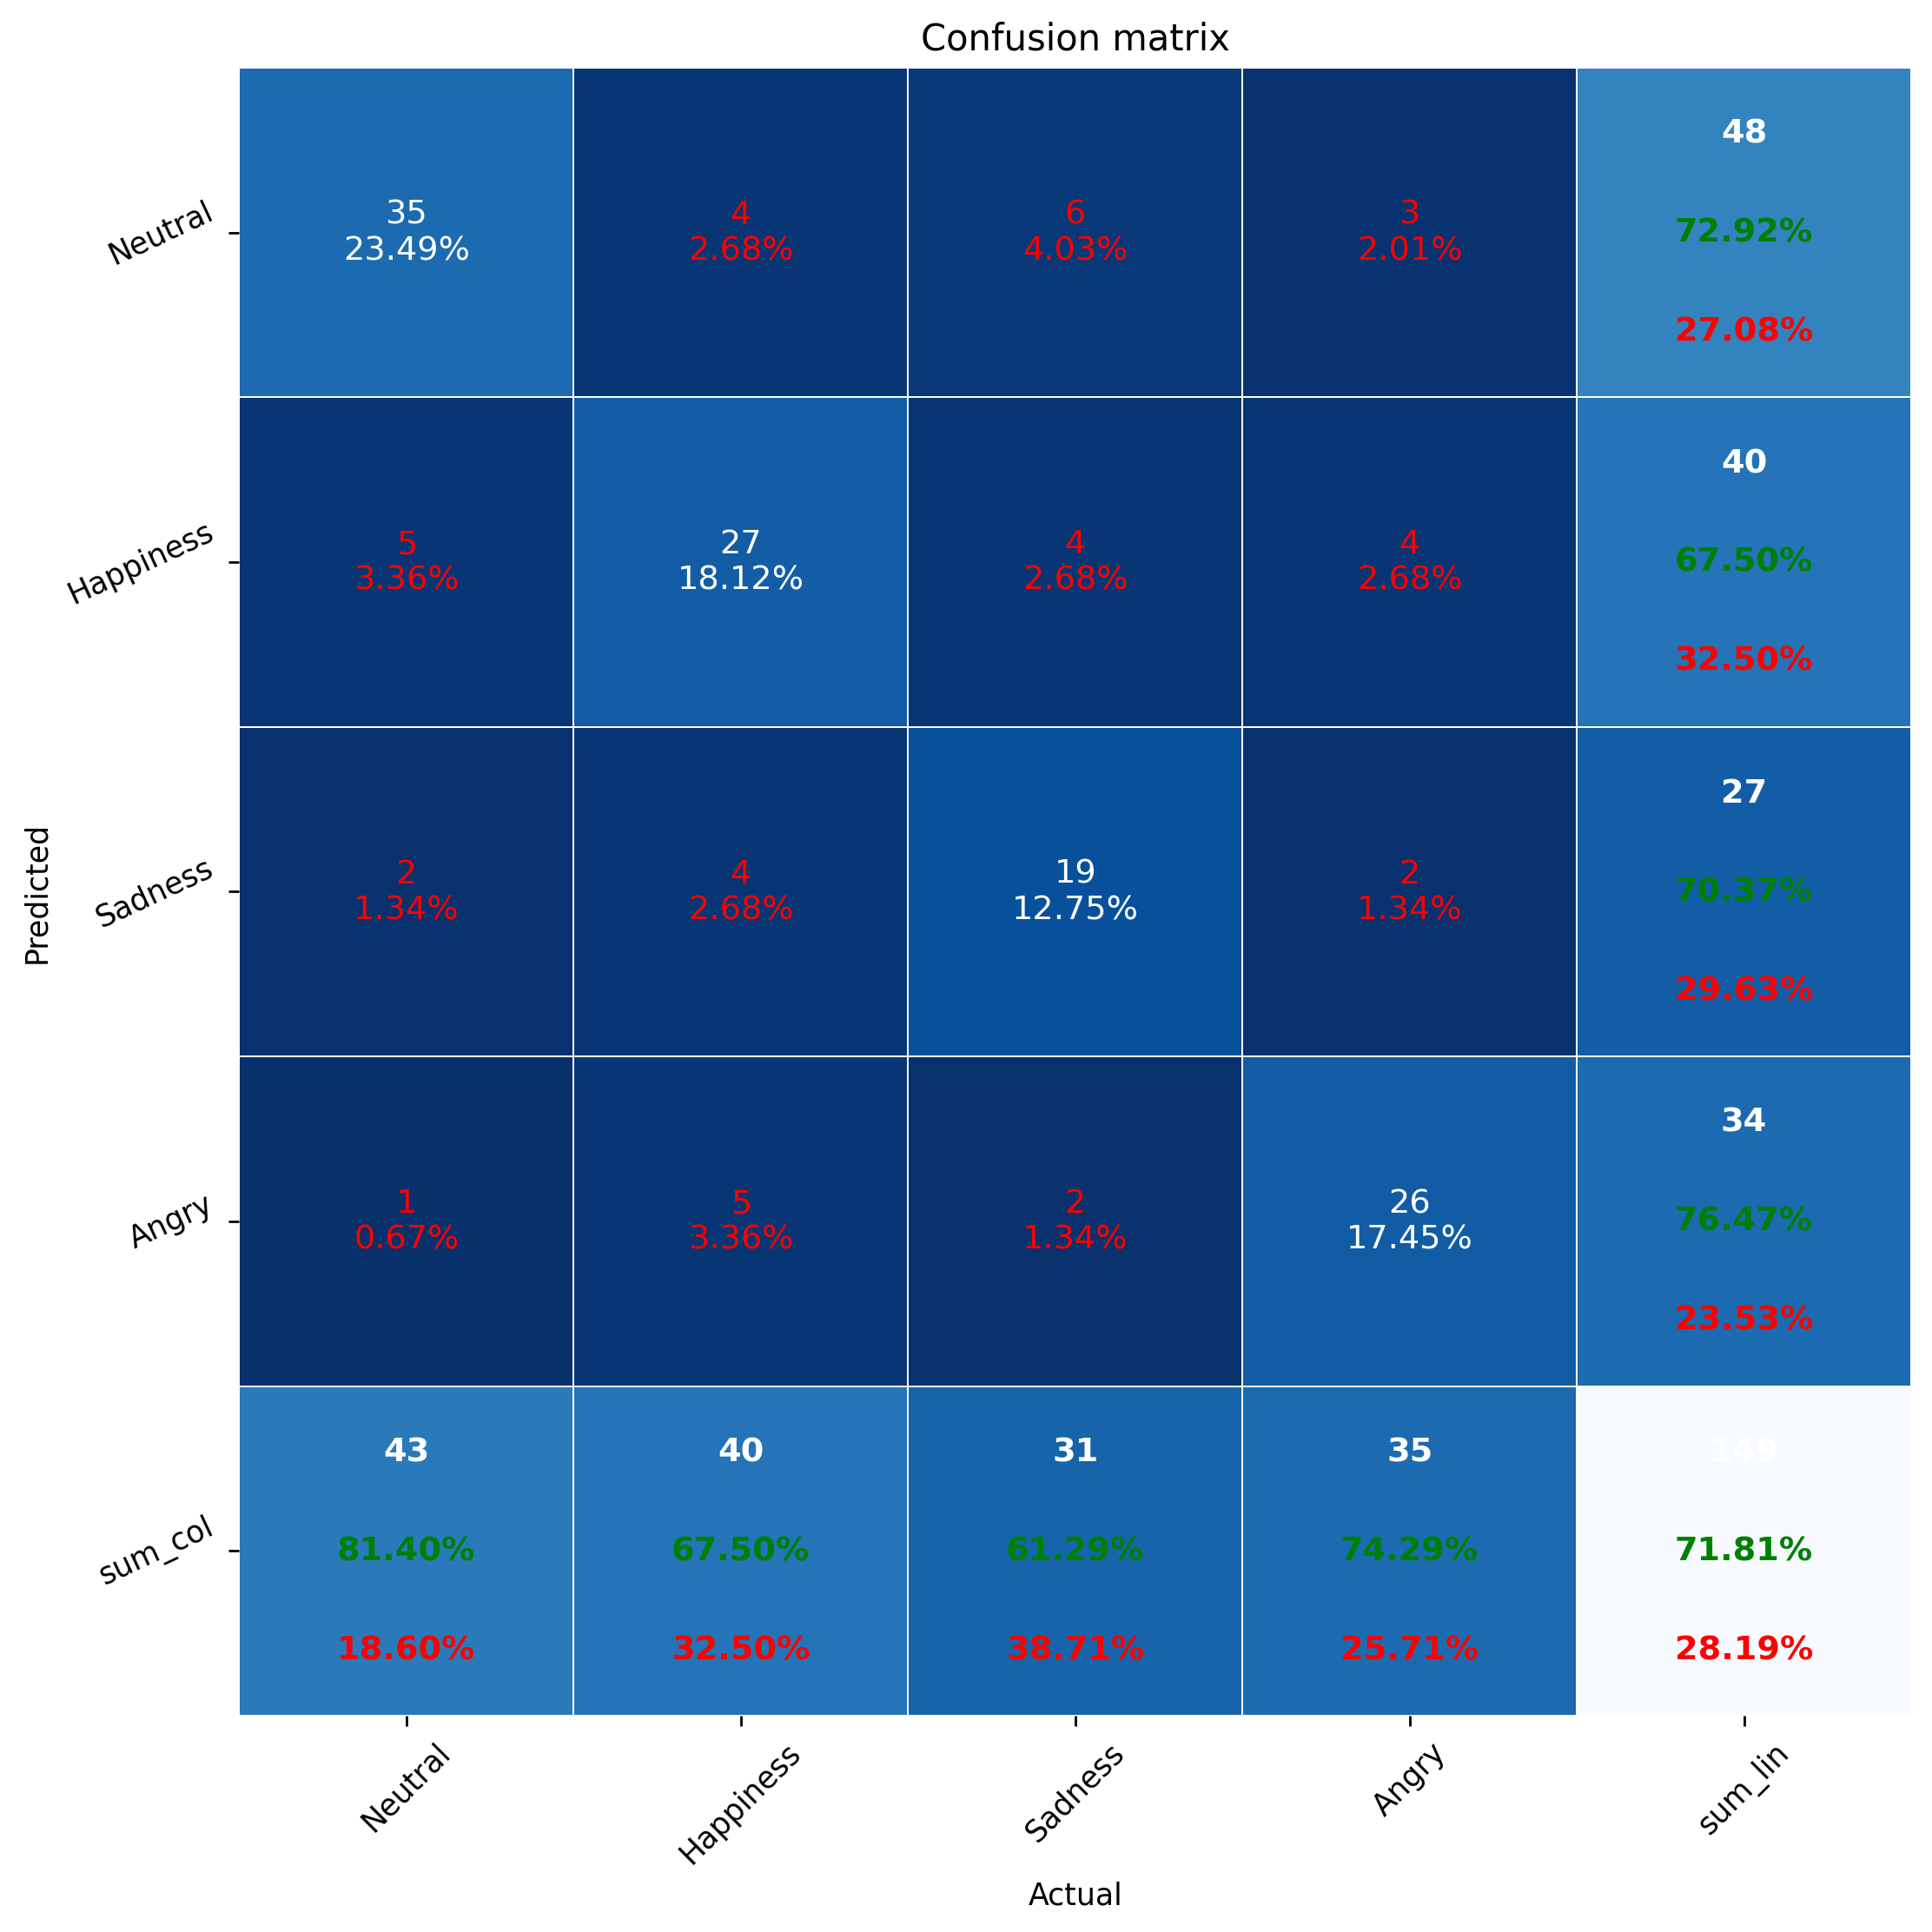

In [42]:
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 250
plt.rcParams['figure.figsize'] = [10.67, 6]

test_model = tf.keras.models.load_model(f"tmp/checkpoint/98-0.72")

preds = test_model.predict(val_x)
preds = np.array([np.argmax(x) for x in preds])

str_labels = ['Neutral', 'Happiness', 'Sadness', 'Angry']

pp_matrix_from_data(preds, val_y, cmap='Blues_r', columns=str_labels)